# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
import random

random_seed = 7337
random.seed = random_seed

training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np

n_train = X_train.shape[0]
assert(n_train == y_train.shape[0])

n_test = X_test.shape[0]
assert(n_test == y_test.shape[0])

image_shape = X_train.shape[1:]
assert(np.array_equal(image_shape, X_test.shape[1:]))

n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import random

%matplotlib inline

labels = pd.read_csv('signnames.csv')
def index_label(index):
    return labels.iloc[index]['SignName']
def index_class(index):
    return labels.iloc[index]['ClassId']

### Perform visual inspection of a sample of labels
def verify_labels(cols=2, rows=2):
    grid = gridspec.GridSpec(rows, cols)
    for c in range(cols):
        for r in range(rows):
            i = random.choice(range(n_classes))
            label = index_label(i)
            class_id = index_class(i)
            p = plt.subplot(grid[r, c])
            p.set_title(label)
            sample_image = X_train[y_train == class_id][0]
            f = p.imshow(sample_image)
            f.axes.get_xaxis().set_visible(False)
            f.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

### Sample labels and images

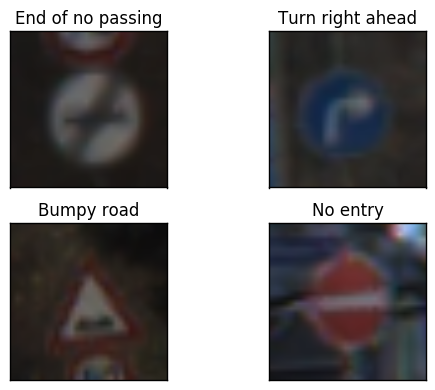

In [35]:
verify_labels()

### Training data histogram by label

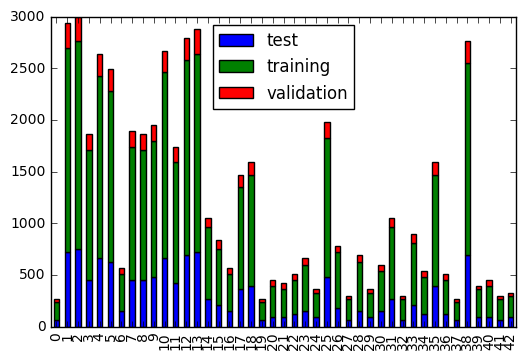

In [36]:
def train_records(class_id, records=y_train):
    return [np.count_nonzero(records == x) for x in class_id]

def valid_records(class_id, records=y_valid):
    return [np.count_nonzero(records == x) for x in class_id]

def test_records(class_id, records=y_test):
    return [np.count_nonzero(records == x) for x in class_id]

frequencies = pd.DataFrame({
        'training': train_records(labels['ClassId']), 
        'validation': valid_records(labels['ClassId']),
        'test': test_records(labels['ClassId'])
        })

frequencies.plot.bar(stacked=True);

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [59]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
binarizer.fit(labels['ClassId'])

### Perform basic normalization
def normalize(x):
    return (2*x - 255) / 255

assert(np.equal(normalize(np.array([[[0, 255], [255, 0]]])), np.array([[[-1, 1], [1, -1]]])).all)

### One hot encoding of labels
def one_hot_encode(y):
    return binarizer.transform(y)
    
### One hot decoding of labels, might be useful later
def one_hot_decode(y):
    return binarizer.inverse_transform(y)

assert one_hot_decode(one_hot_encode([n_classes - 1])) == [[n_classes - 1]]
assert np.argmax(one_hot_encode([n_classes - 1])) == n_classes - 1

X_train_norm, y_train_norm = normalize(X_train), one_hot_encode(y_train)
X_valid_norm, y_valid_norm = normalize(X_valid), one_hot_encode(y_valid)
X_test_norm, y_test_norm = normalize(X_test), one_hot_encode(y_test)

### Create a new dataset of train+valid, might be useful later if k-fold cross validation is used instead
### of the provided train/validation split
X_kfold_norm = np.concatenate((X_train_norm, X_valid_norm), axis=0)
y_kfold_norm = np.concatenate((y_train_norm, y_valid_norm), axis=0)

### Model Architecture

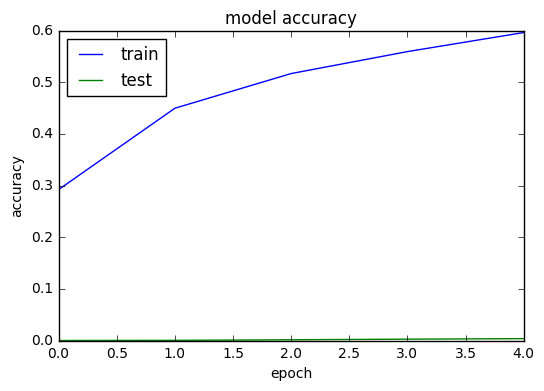

In [66]:
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Activation, Flatten
from keras.models import Sequential

### Define model and hyper parameter space
def keras_model(
    input_shape=(32, 32, 3),
    init='he_normal',
    border_mode='valid',
    kernel_size=3,
    pool_size=2,
    dropout=0.2,
    activation='relu',
    optimizer='adagrad',
    l1_size = 16,
    l2_size = 8,
    l3_size = n_classes*3,
    l4_size = n_classes*2,
    l5_size = n_classes):
    model = Sequential()
    model.add(Convolution2D(nb_filter=l1_size, 
                            nb_row=kernel_size, 
                            nb_col=kernel_size, 
                            init=init,
                            input_shape=input_shape,
                            border_mode=border_mode))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size), 
                           border_mode=border_mode))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Convolution2D(nb_filter=l2_size, 
                            nb_row=kernel_size, 
                            nb_col=kernel_size, 
                            init=init,
                            input_shape=input_shape,
                            border_mode=border_mode))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size), 
                           border_mode=border_mode))
    model.add(Flatten())
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(l3_size))
    model.add(Activation(activation))
    model.add(Dense(l4_size))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(l5_size))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Helper method to train model candidate
def train_keras_model(model, X, y,
                      validation_split=0.0,
                      nb_epoch=20,
                      batch_size=50,
                      verbose=1):
    history = model.fit(X, y, 
                        validation_split=validation_split, 
                        nb_epoch=nb_epoch, 
                        batch_size=batch_size, 
                        verbose=verbose)
    # summarize history for accuracy
    if 'acc' in history.history:
        plt.plot(history.history['acc'])
    else:
        plt.plot(history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    if 'val_categorical_accuracy' in history.history:
        plt.plot(history.history['val_categorical_accuracy'])
        plt.legend(['train', 'test'], loc='upper left')
    elif 'val_acc' in history.history:
        plt.plot(history.history['val_acc'])
        plt.legend(['train', 'test'], loc='upper left')
    else:
        plt.legend(['train'], loc='upper left')        
    plt.show()
    
# Perform a sanity check training run
train_keras_model(keras_model(), X_train_norm, y_train_norm, 
                  validation_split=0.3, 
                  verbose=0, 
                  nb_epoch=5,
                  batch_size=50)

In [ ]:
accuracy = best_model.evaluate(X_test, y_test_one_hot)

print()
print("Test set loss = {}".format(best_accuracy[0]))
print("Test set accuracy = {}".format(best_accuracy[1]))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [67]:
### Perform a Grid Search over a region of the hyperparameter space
### TODO: Reasearch Randomized/ParticleSwarm search methods for hyperparameter search
### TODO: Perform a more exhaustive parameter search (currently costrained by non distributed approach)
### TODO: Research literature for standard ways to perform this search in a non-naive fashion
### TODO: Research possible distributed pipelines for hyperparameter search

import sklearn
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.grid_search import GridSearchCV

### Custom hyperparameter space
### trains candidate models on a reduced number of epochs, this will bias model selection towards faster convergence
### values at the possible expense of final model accuracy; increase epochs below to decrease this bias
### Using default cross validation for GridSearchCV with k = 3
hyper_params = {
    'nb_epoch': [20], 
    'batch_size': [100],
    'dropout': [0.2, 0.4]
}

grid = GridSearchCV(estimator=KerasClassifier(build_fn=keras_model), 
                    param_grid=hyper_params, )
grid_result = grid.fit(X_kfold_norm, y_kfold_norm )
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/20
26139/26139 [==============================] - 3s - loss: 2.3463 - acc: 0.3534     
Epoch 2/20
26139/26139 [==============================] - 2s - loss: 1.5361 - acc: 0.5550     
Epoch 3/20
26139/26139 [==============================] - 2s - loss: 1.2485 - acc: 0.6299     
Epoch 4/20
26139/26139 [==============================] - 2s - loss: 1.0988 - acc: 0.6708     
Epoch 5/20
26139/26139 [==============================] - 2s - loss: 0.9973 - acc: 0.6957     
Epoch 6/20
26139/26139 [==============================] - 2s - loss: 0.9152 - acc: 0.7171     
Epoch 7/20
26139/26139 [==============================] - 2s - loss: 0.8527 - acc: 0.7346     
Epoch 8/20
26139/26139 [==============================] - 2s - loss: 0.8014 - acc: 0.7493     
Epoch 9/20
26139/26139 [==============================] - 2s - loss: 0.7648 - acc: 0.7583     
Epoch 10/20
26139/26139 [==============================] - 2s - loss: 0.7218 - acc: 0.7736     
Epoch 11/20
26139/26139 [========================

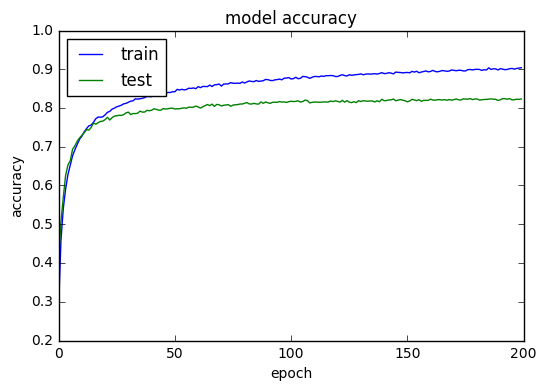

In [71]:
### Train the selected model for full accuracy under hw constraints
best_params = grid_result.best_params_.copy()
if 'batch_size' in best_params:
    best_batch_size = best_params.pop('batch_size')
if 'nb_epoch' in best_params:
    epochs = 20*best_params.pop('nb_epoch')
best_model = keras_model(**best_params)
train_keras_model(best_model, X_kfold_norm, y_kfold_norm, 
                  validation_split=0.1, 
                  verbose=0, 
                  nb_epoch=epochs,
                  batch_size=best_batch_size)

In [73]:
best_accuracy = best_model.evaluate(X_test_norm, y_test_norm)

print()
print("Test set loss = {}".format(best_accuracy[0]))
print("Test set accuracy = {}".format(best_accuracy[1]))

12512/12630 [============================>.] - ETA: 0s
Test set loss = 0.6857277823174085
Test set accuracy = 0.8054631829356166


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

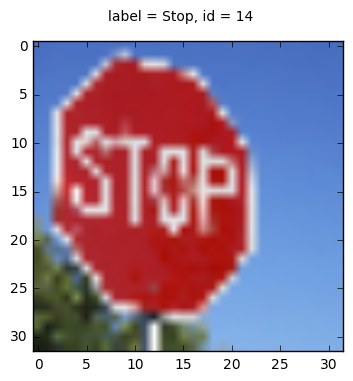

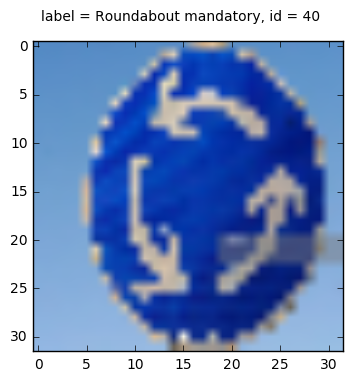

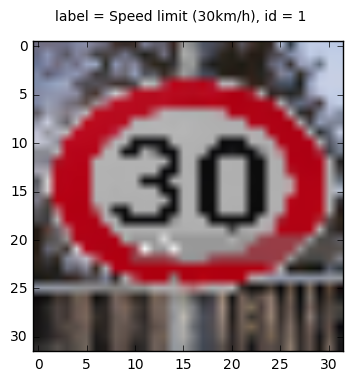

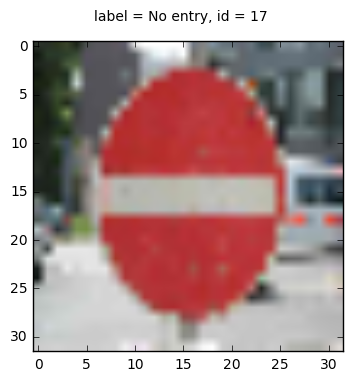

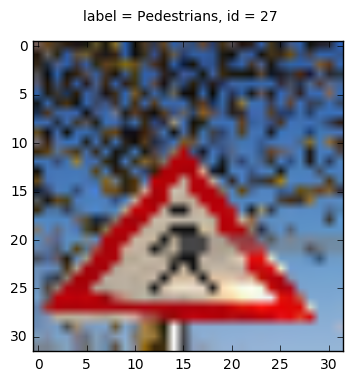

In [131]:
import urllib, cv2

def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

extra_urls = [
    'http://motonauczyciel.pl/media/k2/items/cache/b208182456855b5680dad1bcd630c63f_XL.jpg',
    'http://media.gettyimages.com/photos/german-traffic-signs-picture-id469763323',
    'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381023?s=170667a',
    'http://bicyclegermany.com/Images/Laws/Do-Not-Enter.jpg',
    'http://media.gettyimages.com/photos/german-traffic-signs-picture-id469763319'
]
X_extra = np.array([cv2.resize(url_to_image(x), (32, 32))
                    for x in extra_urls])
for i in range(len(X_extra)):
    X_extra[i] = cv2.cvtColor(X_extra[i], cv2.COLOR_BGR2RGB)
y_extra = np.array([14, 40, 1, 17, 27])

for img, label_index in zip(X_extra, y_extra):
    fig = plt.figure()
    fig.suptitle("label = {}, id = {}".format(index_label(label_index), label_index))
    plt.imshow(img)

### Predict the Sign Type for Each Image

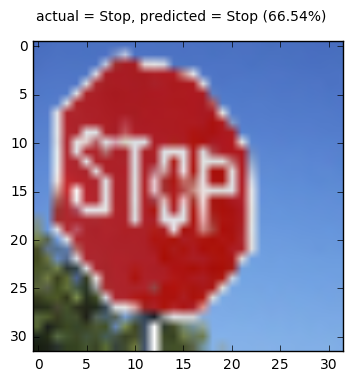

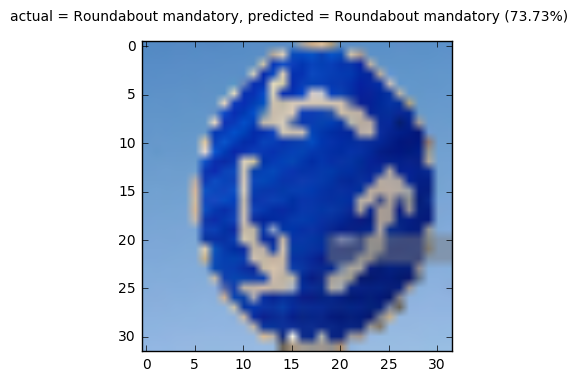

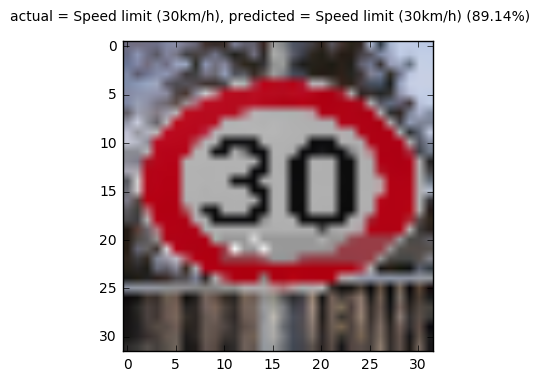

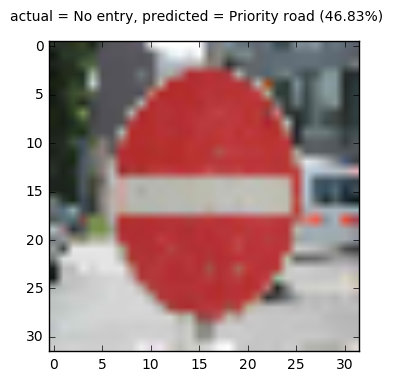

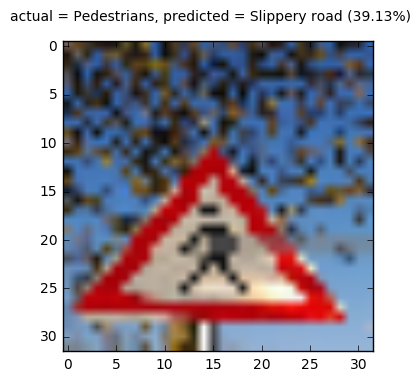

In [136]:
X_extra_norm = normalize(X_extra)
y_extra_norm = one_hot_encode(y_extra)

y_pred = best_model.predict(X_extra_norm)

for img, actual_index, softmax_pred in zip(X_extra, y_extra, y_pred):
    fig = plt.figure()
    pred_index = np.argmax(softmax_pred)
    fig.suptitle("actual = {}, predicted = {} ({:.2f}%)".format(index_label(actual_index), 
                                                                index_label(pred_index),
                                                                softmax_pred[pred_index]*100))
    plt.imshow(img)

### Analyze Performance

In [140]:
extra_loss, extra_accuracy = best_model.evaluate(X_extra_norm, y_extra_norm, verbose = 0)

print("Test set loss (extra) = {:.2f}".format(extra_loss))
print("Test set accuracy (extra) = {:.2f}%".format(extra_accuracy*100))

Test set loss (extra) = 2.28
Test set accuracy (extra) = 60.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [147]:
top_n = 5
for i, actual_index, softmax_pred in zip(range(len(y_extra)), y_extra, y_pred):
    print("Image #{}, top {} softmax predictions:".format(i, top_n))
    top_n_index = np.argsort(softmax_pred)[::-1][:5]
    for j in top_n_index:
        print("  class id: {0:>2}, p: {2:.2f}%, label: {1}".format(str(j), index_label(j), softmax_pred[j]))

Image #0, top 5 softmax predictions:
  class id: 14, p: 0.67%, label: Stop
  class id:  3, p: 0.14%, label: Speed limit (60km/h)
  class id:  2, p: 0.08%, label: Speed limit (50km/h)
  class id:  4, p: 0.07%, label: Speed limit (70km/h)
  class id:  1, p: 0.03%, label: Speed limit (30km/h)
Image #1, top 5 softmax predictions:
  class id: 40, p: 0.74%, label: Roundabout mandatory
  class id: 12, p: 0.17%, label: Priority road
  class id: 38, p: 0.03%, label: Keep right
  class id: 36, p: 0.02%, label: Go straight or right
  class id: 15, p: 0.01%, label: No vehicles
Image #2, top 5 softmax predictions:
  class id:  1, p: 0.89%, label: Speed limit (30km/h)
  class id:  0, p: 0.06%, label: Speed limit (20km/h)
  class id:  2, p: 0.03%, label: Speed limit (50km/h)
  class id:  3, p: 0.01%, label: Speed limit (60km/h)
  class id:  5, p: 0.00%, label: Speed limit (80km/h)
Image #3, top 5 softmax predictions:
  class id: 12, p: 0.47%, label: Priority road
  class id: 35, p: 0.25%, label: Ahea

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 